In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fpath

from lib.gallerosalas.preprocess_aud_raw import preprocess
import lib.gallerosalas.preprocess_common as prepcommon


%load_ext autoreload
%autoreload 2

Appended root directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-mesoscopic/pub-2020-exploratory-analysis


In [2]:
FPS = 20  # Hz
mice = ['mou_9', 'mou_6', 'mou_7', 'mou_5']
extra_mice = ['mou_15_Ariel', 'mou_18_Ariel']

In [3]:
# pathTGT = gui_fpath('root path to TGT')
pathTGT = '/run/user/1000/gvfs/smb-share:server=130.60.51.15,share=neurophysiology-storage2/Gallero'

In [4]:
# pathOverlay = gui_fpath('root path to overlay')
pathOverlay = '/run/user/1000/gvfs/smb-share:server=130.60.51.15,share=neurophysiology-storage2/Gallero/SDT-TDT/overlay'

In [5]:
# pathPreferences = gui_fpath('root path to overlay')
# pathPreferences = '/media/alyosha/Data/TE_data/yasirdata_aud_raw'
pathPreferences = '/media/aleksejs/DataHDD/work/data/yasir/yasirdata_aud_raw'

In [6]:
pathDict = {
    'TGT' : pathTGT,
    'Overlay' : pathOverlay,
    'Preferences' : pathPreferences
}

In [7]:
prep = preprocess(pathDict)

mou_5 2016_12_07
mou_5 2016_12_08
mou_5 2016_12_12
mou_5 2016_12_13
mou_5 2016_12_14
mou_5 2016_12_15
mou_6 2017_05_23
Not found path: /run/user/1000/gvfs/smb-share:server=130.60.51.15,share=neurophysiology-storage2/Gallero/mou_6/2017_05_23/widefield_labview
mou_6 2017_05_24
Not found path: /run/user/1000/gvfs/smb-share:server=130.60.51.15,share=neurophysiology-storage2/Gallero/mou_6/2017_05_24/widefield_labview
mou_6 2017_05_31
Not found path: /run/user/1000/gvfs/smb-share:server=130.60.51.15,share=neurophysiology-storage2/Gallero/mou_6/2017_05_31/widefield_labview
mou_6 2017_06_08
mou_6 2017_06_09
mou_6 2017_06_10
mou_6 2017_06_28
mou_6 2017_06_29
mou_6 2017_07_06
mou_6 2017_07_07
mou_6 2017_07_14
mou_6 2017_07_20
mou_7 2017_07_05
mou_7 2017_07_06
mou_7 2017_07_07
mou_7 2017_07_14
mou_7 2017_07_17
mou_7 2017_07_18
mou_7 2017_07_20
mou_7 2017_07_24
mou_7 2017_07_26
mou_7 2017_07_27
mou_7 2017_08_01
mou_7 2017_08_02
mou_7 2017_08_03
mou_7 2017_08_04
mou_9 2017_12_04
mou_9 2017_12_05
mo

# 1. Test transform on Ref files

Not necessary because already done in texture

# 2. Test transform on Video Files

In [ ]:
%%time
for mousename in sorted(set(prep.dataPaths['mouse'])):
    print(mousename)
    prep.test_transform_vids(mousename)

# 3. Pool-process video files

In [ ]:
prep.process_video_files('mou_5', skipExisting=False)

## 3.1 Test if result is sensible

In [ ]:
import h5py 
rez = []
for idx, row in prep.dataPaths.iterrows():
    session = row['day'] + '_' + row['session']
    fpath = os.path.join(pathPreferences, row['mouse'] + '.h5')    
    
    with h5py.File(fpath, 'r') as f:        
        dataRSP = np.copy(f['data'][session])
        rez += [np.nanmean(dataRSP, axis=(0, 1))]
        
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(np.array(rez), columns=np.arange(27)))

# 4. Pull trial types and times

* Also compute d'

In [ ]:
import h5py

for mouseName in mice:
    with h5py.File(os.path.join(pathPreferences, mouseName + '.h5'), 'a') as f:
        for key in ['metadata', 'accuracy', 'dprime']:
            if key in f.keys():
                print(key)
                del f[key]

In [ ]:
prep.process_metadata_files(pathPreferences)

In [ ]:
for idx, row in prep.dataPaths.iterrows():
    session = row['day'] + '_' + row['session']
    fpath = os.path.join(pathPreferences, row['mouse'] + '.h5')
    with h5py.File(fpath) as f:
        print(fpath, f.keys())
    
    df = pd.read_hdf(fpath, '/metadata/' + session)
    display(df.head())

In [ ]:
prep.extract_timestamps_video(pathPreferences)

# 5. Cleanup bad sessions/trials

In [14]:
prep.metadata_add_selected_column(pathPreferences)

/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2016_12_07_session02'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/pandas/core/generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['trialType', 'Activity'], dtype='object')]

  pytables.to_hdf(
/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2016_12_07_session03'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr(

/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2017_06_09_session06'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2017_06_09_session07'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2017_06_09_session08'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to a

/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2017_07_06_session02'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2017_07_06_session04'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2017_07_06_session05'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to a

/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2017_08_03_session03'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2017_08_04_session01'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/opt/anaconda3/envs/py3qt5/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2017_08_04_session06'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to a

In [31]:
badIdxs = prep.get_trial_idxs_by_timestep_interval(pathPreferences, 'mou_5', '2016_12_07_session02', 43000, 100000)
print(badIdxs)

[116 117 118 119]


In [30]:
prep.mark_trials_bad_by_index(pathPreferences, 'mou_5', '2016_12_07_session02', badIdxs)

    trialType    Activity          timeStamps  selected
0         Hit  quiet_sens 2016-12-07 16:04:51      True
1          FA        None 2016-12-07 16:05:08      True
2       Early        None 2016-12-07 16:05:25      True
3          CR  quiet_sens 2016-12-07 16:05:44      True
4          CR  quiet_sens 2016-12-07 16:06:02      True
..        ...         ...                 ...       ...
115     Early        None 2016-12-07 16:40:10      True
116     Early        None 2016-12-07 16:40:32     False
117        CR  quiet_sens 2016-12-07 16:40:49     False
118        CR  quiet_sens 2016-12-07 16:41:08     False
119     Early        None 2016-12-07 16:41:29     False

[120 rows x 4 columns]


# 6. Baseline subtraction

# 6.1 Plot stitched session, fit poly

**TODO-This**:
* Test if there are trials of mismatching length
* Test if there are sessions with mismatching counts, process
* 

**TODO**:
* Purge mismatching trial counts for trialStruct vs vid:
    - Go over data, delete last
* Very high variance of individual consecutive trials. May render entire idea useless
  - Explore more channels, mice, naive vs expert
  - Compare if Yaro has the same problem
  - Ask Yasir what he thinks about the origin of these fluctuations:
      - Real?
      - Motion artifacts?
      - Sth else?

(98, 200) (98, 200, 27)


<IPython.core.display.Javascript object>


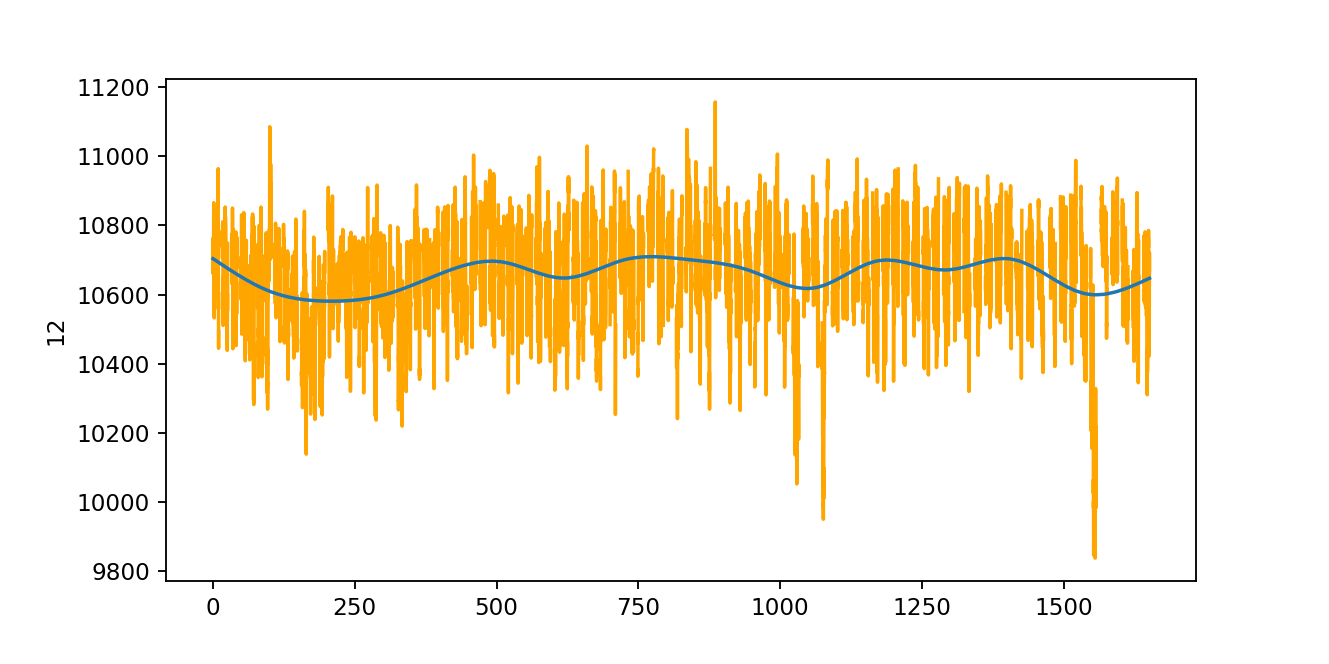

In [46]:
## Testing individual fitness
%matplotlib notebook
times, dataRSP = prep.get_pooled_data_rel_times(pathPreferences, 'mou_5', "2016_12_08_session05", onlySelected=True)
prepcommon.example_poly_fit(times, dataRSP, ord=15, iCh=12)

mou_5 2016_12_07_session02
(120, 200) (120, 200, 27)


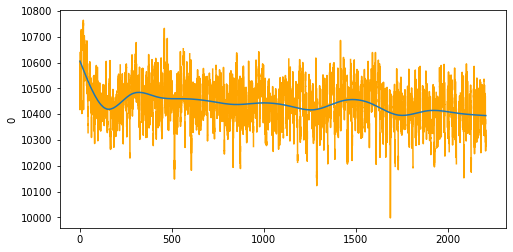

In [45]:
## Testing individual fitness
%matplotlib inline
for idx, row in prep.dataPaths.iterrows():
    try: 
        session = row['day'] + '_' + row['session']
#         session="2017_03_29_session01"
        print(row['mouse'], session)
    
        times, dataRSP = prep.get_pooled_data_rel_times(pathPreferences, row['mouse'], session)
        
        for iCh in range(dataRSP.shape[2]):
            prepcommon.example_poly_fit(times, dataRSP, ord=15, iCh=iCh)
            break
    except:
        print('-- Failed')
    break

# 6.2 Process all sessions

In [8]:
FPS = 20
iMin = 0 * FPS
iMax = 1 * FPS

In [48]:
prep.baseline_subtraction_dff(pathPreferences, iMin, iMax, skipExist=True)

mou_5 2016_12_07_session02
mou_5 2016_12_07_session03
mou_5 2016_12_07_session04
mou_5 2016_12_07_session05
mou_5 2016_12_07_session06
mou_5 2016_12_08_session01
mou_5 2016_12_08_session02
mou_5 2016_12_08_session05
mou_5 2016_12_08_session06
mou_5 2016_12_12_session01
mou_5 2016_12_12_session03
mou_5 2016_12_12_session04
mou_5 2016_12_12_session06
mou_5 2016_12_13_session05
mou_5 2016_12_13_session06
mou_5 2016_12_14_session02
mou_5 2016_12_14_session04
mou_5 2016_12_15_session01
mou_5 2016_12_15_session02
mou_5 2016_12_15_session03
mou_5 2016_12_15_session04
mou_6 2017_06_08_session03
mou_6 2017_06_08_session05
mou_6 2017_06_08_session06
mou_6 2017_06_09_session02
mou_6 2017_06_09_session03
mou_6 2017_06_09_session04
mou_6 2017_06_09_session05
mou_6 2017_06_09_session06
mou_6 2017_06_09_session07
mou_6 2017_06_09_session08
mou_6 2017_06_10_session02
mou_6 2017_06_10_session03
mou_6 2017_06_10_session05
mou_6 2017_06_10_session06
mou_6 2017_06_10_session08
mou_6 2017_06_28_session04
m

In [47]:
prep.baseline_subtraction_poly(pathPreferences, ord=15, skipExist=True)

mou_5 2016_12_07_session02
mou_5 2016_12_07_session03
mou_5 2016_12_07_session04
mou_5 2016_12_07_session05
mou_5 2016_12_07_session06
mou_5 2016_12_08_session01
mou_5 2016_12_08_session02
mou_5 2016_12_08_session05
mou_5 2016_12_08_session06
mou_5 2016_12_12_session01
mou_5 2016_12_12_session03
mou_5 2016_12_12_session04
mou_5 2016_12_12_session06
mou_5 2016_12_13_session05
mou_5 2016_12_13_session06
mou_5 2016_12_14_session02
mou_5 2016_12_14_session04
mou_5 2016_12_15_session01
mou_5 2016_12_15_session02
mou_5 2016_12_15_session03
mou_5 2016_12_15_session04
mou_6 2017_06_08_session03
mou_6 2017_06_08_session05
mou_6 2017_06_08_session06
mou_6 2017_06_09_session02
mou_6 2017_06_09_session03
mou_6 2017_06_09_session04
mou_6 2017_06_09_session05
mou_6 2017_06_09_session06
mou_6 2017_06_09_session07
mou_6 2017_06_09_session08
mou_6 2017_06_10_session02
mou_6 2017_06_10_session03
mou_6 2017_06_10_session05
mou_6 2017_06_10_session06
mou_6 2017_06_10_session08
mou_6 2017_06_28_session04
m